In [1]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import sklearn.metrics
import numpy.random as rd
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers.convolutional import Conv1D
from keras.layers.convolutional import MaxPooling1D
import math as mth

# Загружаем excel-файл
excel_data = pd.read_excel('TestData.xlsx')
# Считываем значения из файла в массивы
Demand = np.array(pd.DataFrame(excel_data, columns=['demand'])).reshape(-1)
Prices = np.array(pd.DataFrame(excel_data, columns=['pricereal'])).reshape(-1)

L=530
UUU=2

# Выбор количества предыдущих состояний для запоминания

n_steps = 30

#Число эпох обучения

Epoch=2000

WWW=25
F=270
x=np.zeros(L+F)
x0=np.zeros(L+F)
x1=np.zeros(L+F)
x2=np.zeros(L+F)
dx1=np.zeros(L+F)
dx2=np.zeros(L+F)

for i in range(L-WWW*UUU):    
    x2[i]=(i/(L-WWW*UUU))*32/2+rd.randint(-99,99)/250

for i in range(L-WWW*UUU,L+int(F/2)+int(WWW*UUU/2)):    
    x2[i]=32/2- (i-L+WWW*UUU)/(int(F/2)+0.5*WWW*UUU)*32/8+rd.randint(-99,99)/250
    
for i in range(L+int(F/2)-int(WWW*UUU/2),L+F): 
    x2[i]=-((i-L-int(F/2)+int(WWW*UUU/2))/(F/2+1/2*WWW*UUU))*32/8+rd.randint(-99,99)/250+32/2-32/8

    
for i in range(L+F):
  
    x0[i]=(i+1)/3
    x[i]=x0[i]/L
    x1[i]=mth.sin(x0[i])/2+mth.sin(x0[i]/5)*5+0.5-(3/10)*x2[i]+(2/5)*abs(x2[i])**1.9+rd.randint(1,99)/50+5
        
for i in range(1,L+F):
    dx1[i]=x1[i]-x1[i-1]
    dx2[i]=x2[i]-x2[i-1]

in_seq1 = np.zeros(len(x2)-1)
in_seq2 = np.zeros(len(x1)-1)
out_seq = np.zeros(len(x1)-1)
for i in range (len(x1)-1):
    in_seq1[i] = x2[i+1]
    in_seq2[i] = x1[i]
    out_seq[i] = x1[i+1]
    
in_seq1 = in_seq1.reshape((len(in_seq1), 1))
in_seq2 = in_seq2.reshape((len(in_seq2), 1))
out_seq = out_seq.reshape((len(out_seq), 1))
dataset = np.hstack((in_seq1, in_seq2, out_seq))

# Разделение последовательностей на пары (вход-выход)
def split_sequences(sequences, n_steps):
    X, y = list(), list()
    for i in range(len(sequences)):
        # find the end of this pattern
        end_ix = i + n_steps
        # check if we are beyond the dataset
        if end_ix > len(sequences):
            break
        # gather input and output parts of the pattern
        seq_x, seq_y = sequences[i:end_ix, :-1], sequences[end_ix-1, -1]
        X.append(seq_x)
        y.append(seq_y)
    return np.array(X), np.array(y)

# Определение суммарной среднеквадратичной ошибки
def mean_squared_error(y_pred, y_true):
    S = 0
    for i in range(len(y_true)):
        S = S + (y_pred[i][0] - y_true[i])**2
    S = S / (2*y_true.size)
    return S

# Конвертация
X, y = split_sequences(dataset, n_steps)
print(X.shape, y.shape)


# Указание количества объектов
n_features = X.shape[2]

Limit = 600

# Разделение на обучающую выборку и валидационную
x_train = X[:Limit]
x_test = X[Limit:]
y_train = y[:Limit] 
y_test = y[Limit:]

# Определение модели
model = Sequential()
model.add(Conv1D(filters=64, kernel_size=2, activation='sigmoid', input_shape=(n_steps, n_features)))
model.add(MaxPooling1D(pool_size=2))
model.add(Flatten())
model.add(Dense(50, activation='sigmoid'))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')

# Обучение модели
model.fit(x_train, y_train, epochs=Epoch, verbose=0)

# Расчет прогнозов в обучении и в валидации
AAA = model.predict(x_train, verbose=0)
BBB = model.predict(x_test, verbose=0)

print("Done")

(770, 30, 2) (770,)
Done


In [2]:
# Массив для запоминаний предсказаний
time = np.zeros(len(y_test))
TTT = np.zeros(len(y_test)+n_steps-1)

# Создание начальных массив для предсказания
in_sim1 = np.zeros(n_steps)
in_sim2 = np.zeros(n_steps)
out_sim = np.zeros(n_steps)
for i in range (n_steps):
    in_sim1[i] = x2[Limit-n_steps+i]
    in_sim2[i] = x1[Limit-n_steps+i-1]
    out_sim[i] = x1[Limit-n_steps+i]

# Цикл предсказаний    
for i in range (len(x_test)+n_steps-1):
    
    #Подготовка данных
    in_sim1 = in_sim1.reshape((len(in_sim1), 1))
    in_sim2 = in_sim2.reshape((len(in_sim2), 1))
    out_sim = out_sim.reshape((len(out_sim), 1))
    dataset = np.hstack((in_sim1, in_sim2, out_sim))

    # Конвертация
    XXX, yyy = split_sequences(dataset, n_steps)
    
    # Расчет прогнозов
    CCC = model.predict(XXX, verbose=0)
    
    #Смещение значений для последующих предказаний
    for count in range (n_steps-1):
        in_sim1[count] = in_sim1[count+1]
        in_sim2[count] = in_sim2[count+1]
        out_sim[count] = out_sim[count+1]
    
    #Внесение новых значений 
    in_sim1[n_steps-1] = x2[Limit+1+i]
    in_sim2[n_steps-1] = out_sim[n_steps-2]
    out_sim[n_steps-1] = CCC[0][0]
    
    TTT[i] = CCC[0][0]
    #Запоминание
    if (i>n_steps):
        time[i-n_steps] = CCC[0][0]

In [3]:
# Расчет ошибок обучения и валидации
mse = mean_squared_error(AAA, y_train)
print("Ошибка обучения", mse)

time = time.reshape((len(time), 1))
Err = mean_squared_error(time, y_test)
print("Ошибка валидации", Err)

Ошибка обучения 0.041489335907823055
Ошибка валидации 39.83910064688232


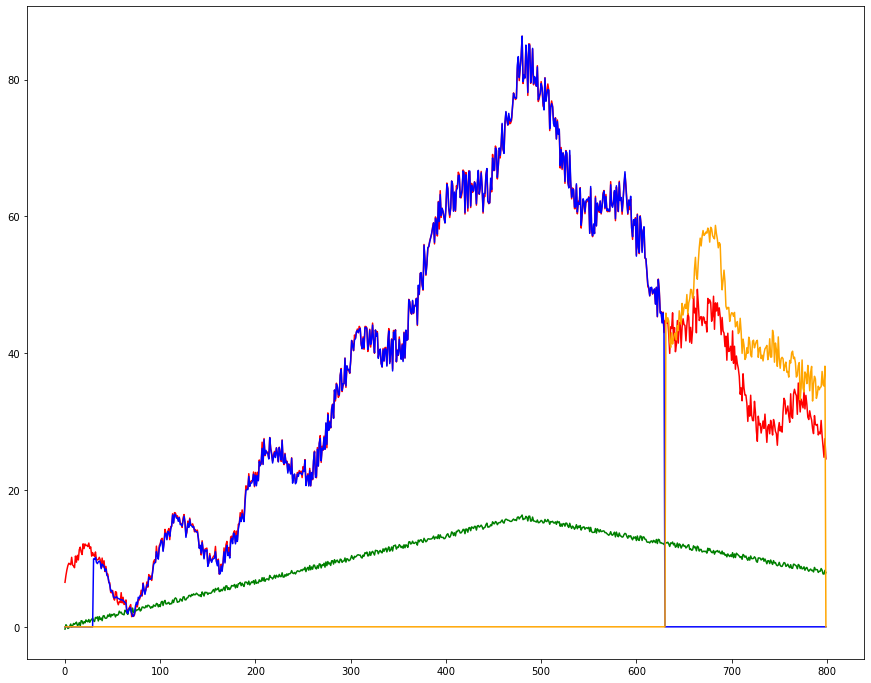

In [4]:
Z1 = np.zeros(len(y_train) + len(y_test) + n_steps)
for i in range (len(y_train)):
    Z1[i+n_steps] = AAA[i][0]
    
Z2 = np.zeros(len(y_train) + len(y_test) + n_steps)
for i in range (len(y_test)):
    Z2[len(y_train) + i + n_steps] = BBB[i][0] 

Z3 = np.zeros(len(y_train) + len(y_test) + n_steps)
for i in range (len(y_test)):
    Z3[len(y_train) + i + n_steps] = time[i] 
    
plt.figure(figsize=(15, 12))
plt.plot(x1, color ="red")
plt.plot(x2, color ="green")
plt.plot(Z1, color ="blue")
#plt.plot(TTT, color ="black")
plt.plot(Z3, color ="orange")
plt.show()